# 第10章 组合和继承
第6章介绍了Scala面向对象的一些基础概念。本章将接着第6章，更详细地介绍Scala对于面向对象编程的支持。
我们将对比类之间的两个最基本的关系：组合和继承。**组合的意思是一个类可以包含对另一个类的引用，利用这个被引用类来帮助它完成任务；而继承是超类/子类的关系。**

除此之外，我们还会探讨抽象类、无参方法、类的扩展、重写方法和字段、参数化字段、调用超类的构造方法、多态和动态绑定、不可重写（final）的成员和类，以及工厂对象和方法。

## 10.1 一个二维的布局类库
我们将创建一个用于构建和渲染二维布局元素的类库，以此作为本章的示例。每个元素表示一个用文本填充的长方形。为方便起见，类库将提供名为“elem”的工厂方法，从传入的数据构造新的元素。例如，可以用下面这个签名的工厂方法创建一个包含字符串的布局元素：
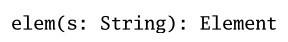

In [1]:
//package org.stairwaybook.layout

object Element {

  private class ArrayElement(
    val contents: Array[String]
  ) extends Element

  private class LineElement(s: String) extends Element {
    val contents = Array(s)
    override def width = s.length
    override def height = 1
  }

  private class UniformElement(
    ch: Char,
    override val width: Int,
    override val height: Int
  ) extends Element {
    private val line = ch.toString * width
    def contents = Array.fill(height)(line)
  }

  def elem(contents:  Array[String]): Element =
    new ArrayElement(contents)

  def elem(chr: Char, width: Int, height: Int): Element =
    new UniformElement(chr, width, height)

  def elem(line: String): Element =
    new LineElement(line)
}
import Element.elem

abstract class Element {
  def contents:  Array[String]

  def width: Int = contents(0).length
  def height: Int = contents.length

  def above(that: Element): Element = {
    val this1 = this widen that.width
    val that1 = that widen this.width
    elem(this1.contents ++ that1.contents)
  }

  def beside(that: Element): Element = {
    val this1 = this heighten that.height
    val that1 = that heighten this.height
    elem(
      for ((line1, line2) <- this1.contents zip that1.contents) 
      yield line1 + line2)
  }

  def widen(w: Int): Element = 
    if (w <= width) this
    else {
      val left = elem(' ', (w - width) / 2, height) 
      val right = elem(' ', w - width - left.width, height)
      left beside this beside right
    }

  def heighten(h: Int): Element = 
    if (h <= height) this
    else {
      val top = elem(' ', width, (h - height) / 2)
      val bot = elem(' ', width, h - height - top.height)
      top above this above bot
    }

  override def toString = contents mkString "\n"
}

object LayoutElement {
  def main(args: Array[String]) {
    
    println("example [\n" + example + "\n]")
  }

  def example = {
    val column1 = elem("hello") above elem("***")
    val column2 = elem("***") above elem("world")
    column1 beside column2
  }
}

defined object Element
import Element.elem


defined class Element
defined object LayoutElement

就像你看到的，我们用一个名为Element的类型来对元素建模。可以对一个元素调用above或beside，传入另一个元素，来获取一个将两个元素结合在一起的新元素。例如，下面这个表达式将创建一个由两列组成的更大的元素，每一列的高度都为2：

In [8]:
println(LayoutElement.example)

hello *** 
 *** world


布局元素很好地展示了这样一个系统：在这个系统中，对象可以通过组合操作符的帮助由简单的部件构建出来。本章将定义那些可以从数组、线和矩形构造出元素对象的类，这些基础的元素对象是我们说的简单的部件，我们还会定义组合操作符above和beside。这样的组合操作符通常也被称作组合子（combinator），因为它们将某个领域内的元素组合成新的元素。

用组合子来思考通常是一个设计类库的好办法：**对于某个特定的应用领域中对象，它们有哪些基本的构造方式，这样的思考是很有意义的。**简单的对象如何构造出更有趣的对象？如何将组合子有机地结合在一起？最通用的组合有哪些？它们是否满足某种有趣的法则？如果对这些问题你都有很好的答案，那么你的类库设计就走在正轨上。

## 10.2 抽象类
我们的第一个任务是定义Element类型，用来表示元素。由于元素是一个由字符组成的二维矩形，用一个成员contents来表示某个布局元素的内容是合情合理的。内容可以用字符串的数组表示，每个字符串代表一行。因此，由contents返回的结果类型将会是Array[String]。示例10.1给出了相应的代码。


In [10]:
abstract class Element {
    def contents: Array[String]//抽象成员，没有具体的实现方法
}

defined class Element

在这个类中，**contents被声明为一个没有实现的方法**。换句话说，这个方法是Element类的抽象（abstract）成员。**一个包含抽象成员的类本身也要声明为抽象的，做法是在class关键字之前写上abstract修饰符**：

abstract class Element...

修饰符abstract表明该类可以拥有那些没有实现的抽象成员。因此，**不能直接实例化一个抽象类。**尝试这样做将遇到编译错误：


In [10]:
new Element

cmd10.sc:1: class Element is abstract; cannot be instantiated
val res10 = new Element
            ^Compilation Failed

: 

在本章稍后你将看到如何创建Element类的子类，这些子类可以被实例化，**因为它们填充了Element抽象类里缺少的contents定义**。

注意，Element类中的content方法并没有标上abstract修饰符。一个方法只要没有实现（即没有等号或方法体），那么它就是抽象的。<u>**跟Java不同，我们并不需要（也不能）对方法加上abstract修饰符。那些给出了实现的方法叫作具体（concrete）方法。**</u>

另一种在叫法上的区分是<u>声明（declaration）和定义（definition）</u>。Element类声明了content这个抽象方法，但目前并没有定义具体的方法。不过在下一节，我们将通过定义一些具体方法来增强Element。

## 10.3 定义无参方法
接下来，我们将给Element添加方法来获取它的宽度和高度，如示例10.2所示。height方法返回contents中的行数。而width方法返回第一行的长度，如果完全没有内容则返回0（这意味着你不能定义一个高度为0但宽度不为0的元素）。


In [11]:
abstract class Element {
    def contents: Array[String]//抽象成员，没有具体的实现方法
    def height: Int = contents.length
    def width: Int = if(height == 0) 0 else contents(0).length
}

defined class Element

注意，Element的三个方法无一例外都没有参数列表，连空参数列表都没有。举例来说，我们并没有写：
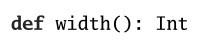
而是不带圆括号来定义这个方法：
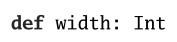
这样的无参方法（parameterless method）在Scala中很常见。与此对应，那些用空的圆括号定义的方法，比如def height（）: Int，被称作空圆括号方法（empty-paren method）。<u>推荐的做法是对于没有参数且只通过读取所在对象字段的方式访问可变状态（确切地说不改变状态）的情况下尽量使用无参方法。这样的做法支持所谓的统一访问原则（uniform access principle）[1]：使用方代码不应受到某个属性是用字段还是用方法实现的影响。</u>

举例来说，完全可以把width和height实现成字段，而不是方法，只要将定义中的def换成val即可：


In [23]:
abstract class Element {
    def contents: Array[String]//抽象成员，没有具体的实现方法
    val height: Int = contents.length
    val width: Int = if(height == 0) 0 else contents(0).length
}

defined class Element

从使用方代码来看，这组定义完全是等价的。唯一的区别是字段访问可能比方法调用略快，因为字段值在类初始化时就被预先计算好，而不是每次方法调用时都重新计算。另一方面，字段需要每个Element对象为其分配额外的内存空间。**因此属性实现为字段好还是方法好，这个问题取决于类的用法，而用法可以是随着时间变化而变化的。核心点在于Element类的使用方不应该被内部实现的变化所影响。**

具体来说，当Element的某个字段被改写成访问函数时，Element的使用方代码并不需要被重新编写，只要这个访问函数是纯的（即它并没有副作用也不依赖于可变状态）。使用方代码并不需要关心究竟是哪一种实现。

到目前为止都还好。不过仍然有个小麻烦，这跟Java处理细节有关。问题在于Java并没有实现统一访问原则。因此Java中要写string.length（）而不是string.length，而对于数组要写array.length，而不是array. lengh（）。无须赘言，这很让人困扰。

为了更好地桥接这两种写法，Scala对于混用无参方法和空括号方法的处理非常灵活。具体来说，可以用空括号方法重写无参方法，也可以反过来。还可以在调用某个不需要入参的方法时省去空括号。例如，如下两行代码在Scala中都是合法的：

In [17]:
Array(1,2,3).toString
Array(1,2,3).toString()
"abc".length
"abc".length()

res16_0: String = "[I@1790581"
res16_1: String = "[I@2c18db"
res16_2: Int = 3
res16_3: Int = 3

从原理上讲，可以对Scala所有无参函数调用都去掉空括号。**不过，我们仍建议在被调用的方法不仅只代表接收该调用的对象的某个属性时加上空括号。**举例来说，空括号的适用场景包括该方法执行I/O、写入可重新赋值的变量（var）、读取接收该调用对象字段之外的var（不论是直接还是间接地使用了可变对象）。这样一来，参数列表就可以作为一个视觉上的线索，告诉我们该调用触发了某个有趣的计算。例如：

In [22]:
"hello".length //没有(),因为没有副作用
println()     //最好别省去()

res21_0: Int = 5

总结下来就是，Scala鼓励我们将那些不接收参数也没有副作用的方法定义为无参方法（即省去空括号）。同时，对于有副作用的方法，不应该省去空括号，因为省掉括号以后这个方法调用看上去就像是字段选择，因此你的使用方可能会对其副作用感到意外。

同理，每当你调用某个有副作用的函数，请确保在写下调用代码时加上空括号。**换一个角度来思考这个问题，如果你调用的这个函数执行了某个操作，就加上括号，而如果它仅仅是访问某个属性，则可以省去括号。**

## 10.4 扩展类
我们仍然需要有某种方式创建新的元素对象。你已经看到“new Element”是不能用的，因为Element类是抽象的。因此，要实例化一个元素，需要创建一个扩展自Element的子类，并实现contents这个抽象方法。示例10.3给出了一种可能的做法：


In [26]:
class ArrayElement(conts: Array[String]) extends Element {
    def contents: Array[String] = conts
}

defined class ArrayElement

ArrayElement类被定义为扩展（extend）自Element类。跟Java一样，可以在类名后面用extends子句来表达：
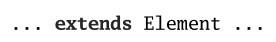
这样的extends子句有两个作用：它使得ArrayElement类从Element类继承（inherit）所有非私有的成员，并且它也让ArrayElement的类型成为Element类型的子类型（subtype）。由于ArrayElement扩展自Element， ArrayElement类被称作Element类的子类（subclass）。反过来讲，Element是ArrayElement的超类（superclass）。**如果你去掉extends子句，Scala编译器会默认假定你的类扩展自scala.AnyRef**，这对应到Java平台跟java. lang.Object相同。因此，Element类默认也扩展自AnyRef类。可以从图10.1中看到这些继承关系。
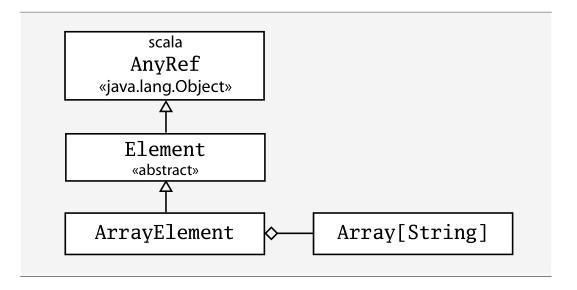
继承（inheritance）的意思是超类的所有成员也是子类的成员，但是有两个例外。**一是超类的<u>私有成员</u>并不会被子类继承；二是如果子类里已经实现了相同名称和参数的成员，那么该成员不会被继承。**对后面这种情况我们也说子类的成员重写（override）了超类的成员。如果子类的成员是具体的而超类的成员是抽象的，我们也说这个具体的成员实现（implement）了那个抽象的成员。

例如，ArrayElement里的contents方法重写（或者说实现）了Element类的抽象方法contents。[2]与此不同的是，ArrayElement类从Element类继承了width和height这两个方法。例如，假定有一个ArrayElement ae，可以用ae.width来查询其宽度，就像width是定义在ArrayElement类一样：


In [28]:
val ae = new ArrayElement(Array("hello","world"))
ae.width

ae: ArrayElement = ammonite.$sess.cmd25$Helper$ArrayElement@11e2950
res27_1: Int = 5

子类型（subtying）的意思是子类的值可以被用在任何需要超类的值的场合。例如：

In [29]:
val e: Element = new ArrayElement(Array("hello"))

e: Element = ammonite.$sess.cmd25$Helper$ArrayElement@25e7b4

变量e的类型是Element，因此用于初始化它的值也应该是一个Element。**事实上，初始值的类型是ArrayElement。这是可以的，因为ArrayElement类扩展自Element，这样，ArrayElement类型是与Element类型兼容的。**[3]

图10.1还展示了ArrayElement和Array[String]之间存在的组合（composition）关系。这个关系被称为组合，因为ArrayElement是通过使用Array[String]组合出来的，Scala编译器会在为ArrayElement生成的二进制类文件中放入一个指向传入的conts数组的字段。我们将在本章稍后的10.11节探讨关于组合和继承的设计考量点。

## 10.5 重写方法和字段
统一访问原则只是Scala比Java在处理字段和方法上更加统一的一个方面。另一个区别是Scala中字段和方法属于同一个命名空间。这使得用字段重写无参方法变为可能。举例来说，可以将ArrayElement类中的contents实现从方法改成字段，这并不需要修改Element类中的contents定义，如示例10.4所示：


In [30]:
class ArrayElement(conts: Array[String]) extends Element {
    val contents: Array[String] = conts
}

defined class ArrayElement

这个版本的ArrayElement中的contents字段（用val定义）是Element类的contents方法（用def定义）的一个没有问题的好实现。另一方面，Scala也禁止在同一个类中使用相同的名称命名字段和方法，在Java中这是允许的。

例如，下面这个Java类可以正常编译：
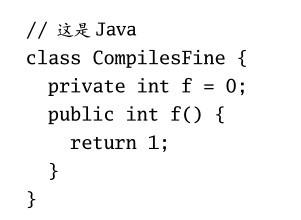
相应的Scala类则不能：

In [30]:
class WontCompile {
    private var f = 0 //不能编译，因为字段
    def f = 1          //和方法重名了
}

cmd30.sc:3: method f is defined twice;
  the conflicting variable f was defined at line 2:17
    def f = 1          //和方法重名了
        ^Compilation Failed

: 

一般来说，Scala只有两个命名空间用于定义，不同于Java的四个。Java的四个命名空间分别是：字段、方法、类型和包，而Scala的两个命名空间分别是：

● 值（字段、方法、包和单例对象）

● 类型（类和特质名）

Scala将字段和方法放在同一个命名空间的原因正是为了让你可以用v a l来重写一个无参方法，这在Java中是不允许的。[4]

## 10.6 定义参数化字段
让我们再来看看前一节定义的ArrayElement类。它有一个conts参数，这个参数存在的唯一目的就是被拷贝到contents字段上。参数的名称选用conts也是为了让它看上去跟字段名contents相似但又不至于跟它冲突。这是个“代码的坏味道”（code smell），是你的代码可能存在不必要的冗余和重复的一种信号。

**可以通过将参数和字段合并成参数化字段（parametric field）定义的方式来避免这个坏味道**，如示例10.5所示：


In [34]:
class ArrayElement(val contents: Array[String]) extends Element
val ae = new ArrayElement(Array("hello","world"))
ae.width

defined class ArrayElement
ae: ArrayElement = ammonite.$sess.cmd33$Helper$ArrayElement@f1d250
res33_2: Int = 5

注意，现在contents参数前面放了一个val。这是同时定义参数和同名字段的简写方式。具体来说，ArrayElement类现在具备一个（不能被重新赋值的）contents字段，该字段可以被外界访问到。该字段被初始化为参数的值。这就好像类定义是如下的样子，其中x123是这个参数的一个任意起的新名：
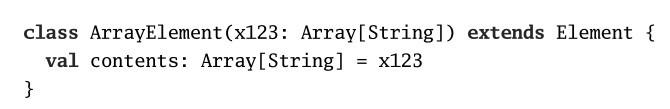
你也可以在类参数的前面加上var，这样的话对应的字段就可以被重新赋值。最后，你还可以给这些参数化字段添加修饰符，比如private、protected[5]或者overried，就像你能够对其他类成员做的那样。例如下面这些类定义：

In [39]:
  class Cat {
    val dangerous = false
  }
  class Tiger(
    override val dangerous: Boolean,
    private var age: Int
  ) extends Cat

val cat = new Cat()
cat.dangerous
val tiger = new Tiger(true,10)
tiger.dangerous

defined class Cat
defined class Tiger
cat: Cat = ammonite.$sess.cmd38$Helper$Cat@7ba8c2
res38_3: Boolean = false
tiger: Tiger = ammonite.$sess.cmd38$Helper$Tiger@1756946
res38_5: Boolean = true

Tiger的定义是如下这个包含重写成员dangerous和私有成员age的类定义的简写方式：

In [40]:
class Cat(val dangerous: Boolean = false)
class Tiger(param1: Boolean, param2: Int) extends Cat {
    override val dangerous = param1
    private var age = param2
}

val cat = new Cat()
cat.dangerous
val tiger = new Tiger(true,10)
tiger.dangerous

defined class Cat
defined class Tiger
cat: Cat = ammonite.$sess.cmd39$Helper$Cat@782228
res39_3: Boolean = false
tiger: Tiger = ammonite.$sess.cmd39$Helper$Tiger@1d5bf2c
res39_5: Boolean = true

这两个成员都通过对应的参数初始化。我们选择param1和param2这两个名字是非常随意的，重要的是它们并不跟当前作用域的其他名称相冲突。